In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

Creates initial random data in frequency domain. N is the max number of samples, while M is the samples being populated with random data

In [5]:
N = 64 #### Best
# N = 128 ### worked with aaron
M = (N//2)-1

d_tilda = np.zeros(N) + 1j*np.zeros(N)
print(d_tilda.shape)


dM_tilda =   np.exp(1j*np.random.uniform(0, 2*np.pi, size=M))
conj_dM = np.conjugate(dM_tilda)[::-1]
print(dM_tilda.shape , conj_dM.shape)
print(d_tilda[1:M+1].shape)
d_tilda[1:M+1] = dM_tilda
d_tilda[-M:] = conj_dM


(64,)
(31,) (31,)
(31,)


Inverse fourier transform the random data. d_int is the resulting data turned into intergers under 14 bits, the max value of the DAC on the Red Pitaya

(64,)


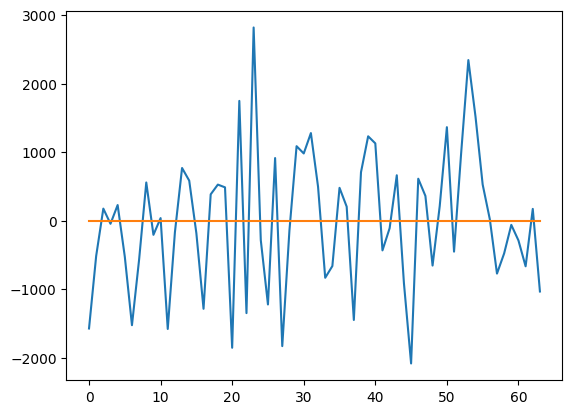

In [3]:
d = np.fft.ifft(d_tilda)
freq = np.fft.fftshift(np.fft.fftfreq(d_tilda.shape[0]))
print(d.shape)
d_back = np.fft.fft(d)
d_int = np.round(d*(2**13-1))


plt.figure()
# plt.plot(d.real)
# plt.plot(d.imag)
plt.plot(d_int.real)
plt.plot(d_int.imag)
# plt.plot(freq, np.fft.fftshift(np.abs(d_tilda)))
# plt.plot(freq, np.fft.fftshift(np.abs(d_back)), linestyle='--')
# plt.plot(freq, np.abs(np.fft.fftshift(d_tilda)))
plt.show()

In [14]:
def sqrt(x):
    return np.where(x < 0, 1j * np.sqrt(-x), np.sqrt(x))


Copies of the transformed data are repeated a T number of times, then Fourier transformed. Result is equally valued spikes seperated at T intervals 

max spike 1.0000000000000004
(1024,)


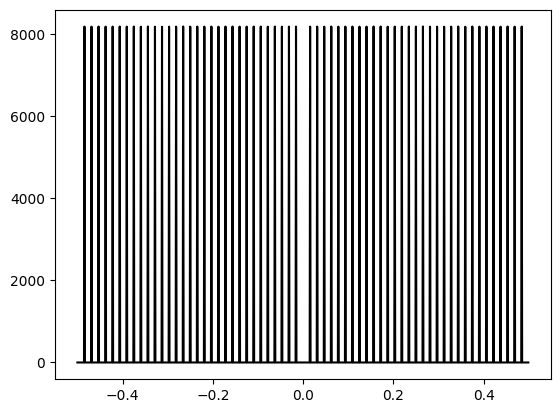

In [7]:
T = 16
# T = 8 ### Worked with aaron
index = T*2
start = index-T
repeat = np.tile(d.real, T)
int_repeat = np.tile(d_int.real, T)

# int_repeat = sqrt(int_repeat)

freqs = np.fft.fftfreq(repeat.size)


repeat_fft = np.fft.fft(repeat)/T 
int_repeat_fft = np.fft.fft(int_repeat)/T
print('max spike', np.max(np.abs((repeat_fft))))
print(int_repeat_fft.shape)

plt.figure()
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(np.abs(int_repeat_fft)), color='black')
# plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(np.abs(repeat_fft)), color='black')
plt.show()

The repeated data is then saved to be produced by the DAC

In [18]:
saved_file = int_repeat
print(saved_file.shape) # Shape of the data should not exceed 1024, due to simulink design. Possible to increase?
print(T, N)
# np.save('/home/dominiv/simulink/dac/notebooks/d_int_repeat_64shift.npy', int_repeat.real)
np.savez(f'/home/dominiv/simulink/dac/notebooks/d_int_{T}set{N}sam.npz', data=saved_file) ### 16set64 is best

(1024,)
16 64
